In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
import re
from convex_optimization_results_check import Network, Investors, Consumers, Example_Anaheim, Example, Example_6node, Example_3node
from Transportaion_test_systems import import_matrix, transportation_network_topo
import math

In [2]:
def getNumbers(str):
    array = re.findall(r'[0-9]+', str)
    return array

### Loading network parameters

In [3]:
congestion = False 
identical_scen = False 
Ntw = Example_6node(identical_scen, congestion)
# Ntw.C.b3

growth at scen  1 :  1.0268728488224803
growth at scen  2 :  1.1694867473874464
growth at scen  3 :  1.1527549237953227
growth at scen  4 :  1.0510138051478843
growth at scen  5 :  1.0990870174183882


### Adding results paths

In [5]:
root = (os.getcwd())
results_path = root + '/Results'
directory_contents = sorted(os.listdir(results_path))
results_folders=[]
# for item in directory_contents:
#     if os.path.isdir(item):
# #         print(getNumbers(item))
#         results_folders.append(item)
        
final_results_path = os.path.join(results_path, directory_contents[-1])
# final_results_path = os.path.join(results_path, 'Results_20211121_1648')
determenistic_result_directory = os.path.dirname(os.getcwd()) + '/script_v8_deterministic_speed_up'

In [6]:
directory_contents

['.ipynb_checkpoints',
 'Resulting_exsu.csv',
 'Resulting_prices.csv',
 'Resulting_scendiff.csv',
 'Results_20220124_1235',
 'Results_20220124_2255']

### Figures setup

In [7]:
from collections import namedtuple, OrderedDict
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['lines.linewidth'] = 2
 
mpl.rc('font',family='Times New Roman', size=20)
fnt_size=30
fnt_size2=20
csfont = {'fontname':'Times New Roman',
                  'size': fnt_size,
                 'fontweight':'bold'}
csfont2 = {'fontname':'Times New Roman',
                  'size': fnt_size2}

Color = namedtuple('RGB','red, green, blue')
class RGB(Color):
    def hex_format(self):
        return '#{:02X}{:02X}{:02X}'.format(self.red,self.green,self.blue)

### Helper functions for reading results

In [8]:
def data_reader(file_name, result_type):
    
    
    scenarios = []
    nodes = []
    value = []
    value_dict={}
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            while("" in row):
                row.remove("")
#         row_numbers = getNumbers(row)
            scenarios.append(int(getNumbers(row[0])[0]))
            nodes.append(int(getNumbers(row[1])[0]))
            value.append(float(row[-1]))
            if result_type == 'Stochastic':
                value_dict[int(getNumbers(row[1])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
            elif result_type == 'Deterministic':
                value_dict[int(getNumbers(row[0])[0])] = float(row[-1])
    if result_type == 'Stochastic':        
        value_stochastic_dict= {'Nodes':nodes, 'Scenarios':scenarios, 'Values':value}
        value_stochastic_df = pd.DataFrame(value_stochastic_dict)
        
    elif result_type == 'Deterministic':        
        value_stochastic_dict= {'Nodes':nodes, 'Values':value}
        value_stochastic_df = pd.DataFrame(value_stochastic_dict)
            
    return value_stochastic_df, value_dict

def traffic_data_reader(file_name, traffic_type, results_type):
    
    if traffic_type == 'q':
        q={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                if results_type == 'Stochastic':
                    if float(row[-1]) == 0:
                        q[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[0])[0])] = float(row[-1]) + 0.00001
                    else:
                        q[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type == 'Deterministic':
                    if float(row[-1]) == 0:
                        q[int(getNumbers(row[0])[0]),int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0])] = float(row[-1]) + 0.00001
                    else:
                        q[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0])] = float(row[-1])
                
        return q
    
    elif traffic_type == 'x':
        x={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                    
                if results_type == 'Stochastic':
                    x[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[5])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type == 'Deterministic':
                    x[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0])] = float(row[-1])
                
        return x
    
    elif traffic_type == 'lamda':
        lamda={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                if results_type =='Stochastic':
                    lamda[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type =='Deterministic':
                    lamda[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0])] = float(row[-1])
        return lamda
    
    elif traffic_type == 'mu':
        mu={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                if results_type == 'Stochastic':
                    mu[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type == 'Deterministic':
                    mu[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0])] = float(row[-1]) 
        return mu
    
    else:
        print('Invalid traffic type; valid options are: q, x, lamda, mu')

# Prices

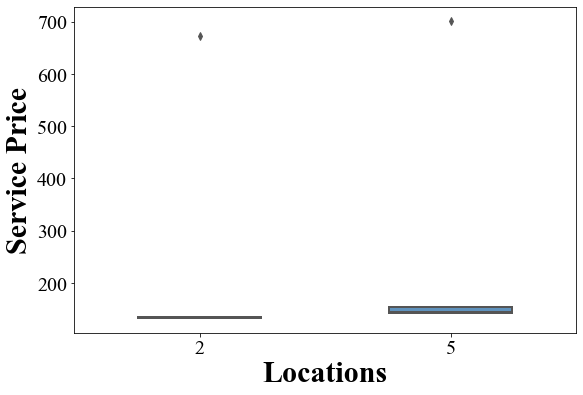

In [9]:
price_file_stochastic = os.path.join(final_results_path, 'Resulting_prices_Stochastic.csv')



prices_stochastic_df, rho_stochastic = data_reader(file_name=price_file_stochastic,result_type='Stochastic')


combined_prices_df = pd.DataFrame()
combined_prices_df['Nodes'] = list(prices_stochastic_df.Nodes)
combined_prices_df['Scenarios'] = list(prices_stochastic_df.Scenarios) 
combined_prices_df['Values'] = list(prices_stochastic_df.Values)
combined_prices_df['Types'] = ['Stochastic']*len(prices_stochastic_df.Nodes)


fig, ax = plt.subplots()
my_pal = {"Stochastic": RGB(79/255,148/255,205/255), "Investors": RGB(255/255,128/255,0), 'CDA': 'red'}
ax = sns.boxplot(x='Nodes', y='Values', data=combined_prices_df, hue='Types', linewidth=2, width=0.5, palette = my_pal)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Service Price",**csfont);
# legend = plt.legend(fontsize=20, frameon=False);
ax.get_legend().remove()
# legend = plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)
# plt.savefig('./Figures/rho.png',dpi=500, format='png', bbox_inches='tight')

# Services (g)

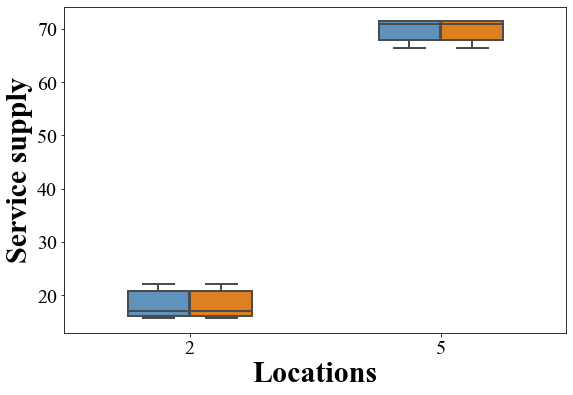

In [10]:
service_file_stochastic = os.path.join(final_results_path, 'Resulting_services_Stochastic.csv')
service_file_stochastic_investors = os.path.join(final_results_path, 'Resulting_services_Investors.csv')



services_df_stochastic, g_stochastic = data_reader(file_name=service_file_stochastic,result_type='Stochastic')
services_df_stochastic_investors, g_stochastic_investors = data_reader(file_name=service_file_stochastic_investors,result_type='Stochastic')
combined_services_df = pd.DataFrame()
combined_services_df['Nodes'] = list(services_df_stochastic.Nodes) + list(services_df_stochastic_investors.Nodes)
combined_services_df['Scenarios'] = list(services_df_stochastic.Scenarios) + list(services_df_stochastic_investors.Scenarios)
combined_services_df['Values'] = list(services_df_stochastic.Values) + list(services_df_stochastic_investors.Values)
combined_services_df['Types'] = ['Stochastic']*len(services_df_stochastic.Nodes) + ['Investors']*len(services_df_stochastic_investors.Nodes)


fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_services_df, hue='Types', linewidth=2, width=0.5, palette = my_pal)
# ax.set_ylim(480,800)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Service supply",**csfont);
legend = plt.legend(loc='upper left',  title='Types',fontsize=20, frameon=False);
ax.get_legend().remove()
# legend = plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)
# plt.savefig('./Figures/g.png',dpi=500, format='png', bbox_inches='tight')

# Capacity

In [11]:
capacities_file_stochastic = os.path.join(final_results_path, 'Resulting_capacities_Stochastic.csv')
capacities_file_stochastic_investors= os.path.join(final_results_path, 'Resulting_capacities_Investors.csv')


capacity_df_stochastic, c_stochastic = data_reader(file_name=capacities_file_stochastic,result_type='Stochastic')
capacity_df_stochastic_investors, c_stochastic_investors = data_reader(file_name=capacities_file_stochastic_investors,result_type='Stochastic')

print("Capacities      Stochastic         Investors")
for k in Ntw.I.K:
    print('Node %i:         %f          %f'%(k,c_stochastic[k,1],c_stochastic_investors[k,1]))
    

# combined_capacity_df = pd.DataFrame()
# combined_capacity_df['Nodes'] = list(capacity_df_stochastic.Nodes) + list(capacity_df_stochastic_investors.Nodes)
# combined_capacity_df['Scenarios'] = list(capacity_df_stochastic.Scenarios) + list(capacity_df_stochastic_investors.Scenarios)
# combined_capacity_df['Values'] = list(capacity_df_stochastic.Values) + list(capacity_df_stochastic_investors.Values)
# combined_capacity_df['Types'] = ['Stochastic']*len(capacity_df_stochastic.Nodes) + ['Investors']*len(capacity_df_stochastic_investors.Nodes)


# fig, ax = plt.subplots()
# ax = sns.boxplot(x='Nodes', y='Values', data=combined_capacity_df, hue= 'Types', linewidth=2, width=0.5, palette = my_pal)
# ax.set_xlabel("Locations",**csfont)
# ax.set_ylabel("Capacity",**csfont);
# legend = plt.legend(fontsize=20, frameon=False);
# ax.get_legend().remove()
# plt.savefig('./Figures/c.png',dpi=500, format='png', bbox_inches='tight')

Capacities      Stochastic         Investors
Node 2:         22.166364          22.166364
Node 5:         71.392576          71.392576


# Traffic

In [12]:
Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_traffic_Stochastic.csv')
Traffic_file_CDA = os.path.join(final_results_path, 'Resulting_traffic_CDA.csv')


q_stochastic = traffic_data_reader(Traffic_file_stochastic,'q','Stochastic')
q_stochastic_CDA = traffic_data_reader(Traffic_file_CDA,'q','Stochastic')


Link_Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_link_traffic_Stochastic.csv')
Link_Traffic_file_CDA = os.path.join(final_results_path, 'Resulting_link_traffic_CDA.csv')

x_stochastic = traffic_data_reader(Link_Traffic_file_stochastic, 'x', 'Stochastic')
x_stochastic_CDA = traffic_data_reader(Link_Traffic_file_CDA, 'x', 'Stochastic')



lamda1_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda1_Stochastic.csv')
lamda1_file_CDA = os.path.join(final_results_path, 'Resulting_lamda1_CDA.csv')


lamda1_stochastic = traffic_data_reader(lamda1_file_stochastic, 'lamda', 'Stochastic')
lamda1_stochastic_CDA = traffic_data_reader(lamda1_file_CDA, 'lamda', 'Stochastic')

lamda2_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda2_Stochastic.csv')
lamda2_file_CDA = os.path.join(final_results_path, 'Resulting_lamda2_CDA.csv')

lamda2_stochastic = traffic_data_reader(lamda2_file_stochastic, 'lamda', 'Stochastic')
lamda2_stochastic_CDA = traffic_data_reader(lamda2_file_CDA, 'lamda', 'Stochastic')


mu_file_stochastic = os.path.join(final_results_path, 'Resulting_mu_Stochastic.csv')
mu_file_CDA = os.path.join(final_results_path, 'Resulting_mu_CDA.csv')


mu_stochastic = traffic_data_reader(mu_file_stochastic, 'mu', 'Stochastic')
mu_stochastic_CDA = traffic_data_reader(mu_file_CDA, 'mu', 'Stochastic')


In [14]:
print("q                Stochastic            CDA")

for r in Ntw.C.R:
    for s in Ntw.C.S:
        for k in Ntw.C.K:
            for u in Ntw.Scn.U:
                print('(%i,%i,%i,%i)        %f             %f'%(r,s,k,u,q_stochastic[r,s,k,u],q_stochastic_CDA[r,s,k,u]))

q                Stochastic            CDA
(1,3,2,1)        15.693428             15.693428
(1,3,2,2)        22.166364             22.166364
(1,3,2,3)        20.827818             20.827818
(1,3,2,4)        16.140552             16.140552
(1,3,2,5)        17.037876             17.037876
(1,3,5,1)        4.844029             4.844029
(1,3,5,2)        1.223371             1.223371
(1,3,5,3)        2.227281             2.227281
(1,3,5,4)        4.879724             4.879724
(1,3,5,5)        4.943864             4.943864
(1,6,2,1)        0.000010             0.000010
(1,6,2,2)        0.000010             0.000010
(1,6,2,3)        0.000010             0.000010
(1,6,2,4)        0.000010             0.000010
(1,6,2,5)        0.000010             0.000010
(1,6,5,1)        20.537457             20.537457
(1,6,5,2)        23.389735             23.389735
(1,6,5,3)        23.055098             23.055098
(1,6,5,4)        21.020276             21.020276
(1,6,5,5)        21.981740             21.9817

# Surpluss analysis

### Investors cost calculation

In [15]:
Investors_total_cost = sum (Ntw.Scn.pr[u] *(
    (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) +
    (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

# Investors_total_cost_wo_anti = sum (Ntw.Scn.pr[u] *(
#     (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) +
#     (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
# print('Investors costs       With non-anti      WO non-anti')
# print('                     ', round(Investors_total_cost,4), '     ', round(Investors_total_cost_wo_anti,4))

### Investors objective calculation

In [16]:
Investors_objective = sum(Ntw.Scn.pr[u] *( 
    rho_stochastic[k,u]*g_stochastic[k,u] -
        (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) - 
        (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

# Investors_objective_wo_anti = sum(Ntw.Scn.pr[u] *( 
#     rho_stochastic_wo_anti[k,u]*g_stochastic_wo_anti[k,u] -
#         (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) - 
#         (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
# print('Investors Obj       With non-anti      WO non-anti')
# print('                   ', round(Investors_objective,5), '     ', round(Investors_objective_wo_anti,4))

### Calculating utility and ravel time based on x

In [17]:
def travel_time(Ntw,lamda1,lamda2,mu):
    t={}
    A={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    A[r,s,k,u] = lamda1[r,s,k,r,u] - lamda1[r,s,k,k,u]  + lamda2[r,s,k,k,u] - lamda2[r,s,k,s,u]
                    t[r,s,k,u] = (Ntw.C.b3/(Ntw.C.b1*Ntw.Scn.pr[u])) * A[r,s,k,u]
#                     t[r,s,k,u] = (Ntw.C.b3/Ntw.Scn.pr[u]) * (A[r,s,k,u]- mu[r,s,u])
#                     t[r,s,k,u] = sum(Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((x[i,j,r,s,k,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
                    
    return t

def travel_time_deterministic(Ntw,lamda1,lamda2,mu):
    t={}
    A={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                A[r,s,k] = lamda1[r,s,k,r] - lamda1[r,s,k,k]  + lamda2[r,s,k,k] - lamda2[r,s,k,s]
                t[r,s,k] = (Ntw.C.b3/(Ntw.C.b1)) * A[r,s,k]
#                     t[r,s,k,u] = (Ntw.C.b3/Ntw.Scn.pr[u]) * (A[r,s,k,u]- mu[r,s,u])
#                     t[r,s,k,u] = sum(Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((x[i,j,r,s,k,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
                    
    return t

def Utility_func(Ntw,lamda1,lamda2,mu,q,rho):
    t_time = travel_time(Ntw,lamda1,lamda2,mu)
    U={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    U[r,s,k,u] = Ntw.C.b0[k] - Ntw.C.b1 * t_time[r,s,k,u]- Ntw.C.b3*rho[k,u] * Ntw.C.e[r,s]
                    
                    
    return U

def Utility_func_deterministic(Ntw,lamda1,lamda2,mu,q,rho):
    t_time = travel_time_deterministic(Ntw,lamda1,lamda2,mu)
    U={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                U[r,s,k] = Ntw.C.b0[k] - Ntw.C.b1 * t_time[r,s,k]- Ntw.C.b3*rho[k] * Ntw.C.e[r,s]
                    
                    
    return U

In [18]:
Utility_stochastic = Utility_func(Ntw,lamda1_stochastic,lamda2_stochastic,mu_stochastic,q_stochastic,rho_stochastic)

total_utility = sum (Ntw.Scn.pr[u]*(Utility_stochastic[r,s,k,u] * q_stochastic[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)


### Surplus calculation

In [19]:
Surpluss_stochastic = Investors_objective + sum (Ntw.Scn.pr[u]*(Utility_stochastic[r,s,k,u] * q_stochastic[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)


# print('Surplus       With non-anti      WO non-anti')
# print('              ', round(Surpluss_stochastic,4), '     ', round(Surpluss_stochastic_wo_anti,4))